<a href="https://colab.research.google.com/github/alwanfa/neural-network-exploration/blob/main/ComplexAddingMachine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [178]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import copy
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [189]:
def createDataset(n) :
  x1 = np.random.randint(-10,10, size = n)
  x2 = np.random.randint(-10,10, size = n)
  x = torch.tensor(np.hstack([x1.reshape(-1,1),x2.reshape(-1,1)])).float()
  y = (torch.tensor(x1+x2)+20).long()
  X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2)
  X_devset, X_test, y_devset, y_test = train_test_split(X_test,y_test, test_size=0.5)
  train_dataset = TensorDataset(X_train,y_train)
  dev_dataset = TensorDataset(X_devset,y_devset)
  test_dataset = TensorDataset(X_test,y_test)
  return train_dataset, dev_dataset, test_dataset

In [190]:
train_dataset, dev_dataset, test_dataset = createDataset(10000)
batchsize    = 32
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataset,batch_size=test_dataset.tensors[0].shape[0])
dev_loader  = DataLoader(dev_dataset,batch_size=dev_dataset.tensors[0].shape[0])

In [191]:
print(f"train shape : {train_dataset.tensors[0].shape}")
print(f"devset shape : {dev_dataset.tensors[0].shape}")
print(f"test shape : {test_dataset.tensors[0].shape}")

train shape : torch.Size([8000, 2])
devset shape : torch.Size([1000, 2])
test shape : torch.Size([1000, 2])


In [193]:
for i, j in zip(test_dataset.tensors[0][:10], test_dataset.tensors[1][:10]) :
  print(f"{i[0]} + {i[1]} = {j}")

-6.0 + -1.0 = 13
6.0 + -8.0 = 18
-8.0 + -1.0 = 11
6.0 + 8.0 = 34
7.0 + -2.0 = 25
-1.0 + 9.0 = 28
-7.0 + -9.0 = 4
-3.0 + -4.0 = 13
8.0 + -2.0 = 26
-7.0 + -8.0 = 5


In [169]:
# create a class for the model
def createAddingMachineNet():

  class AddingMachineNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(2,8)

      # ### hidden layer
      self.fc1 = nn.Linear(8,8)
      self.fc2 = nn.Linear(8,8)
      ### output layer
      self.output = nn.Linear(8,41)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)

  # create the model instance
  net = AddingMachineNet()

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [163]:
# test the model with one batch
net,lossfun,optimizer = createAddingMachineNet()

X,y = next(iter(train_loader))
yHat = net(X)

# values are log-probability of each number (0-9)
# print(torch.exp(yHat))

# now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

 
Loss:
tensor(5.1258, grad_fn=<NllLossBackward0>)


In [198]:
def function2trainTheModel():

  # number of epochs
  numepochs = 50

  theBestModel = {'Accuracy':0, 'net':None}

  # create a new model
  net,lossfun,optimizer = createAddingMachineNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  devsetAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y,)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(dev_loader)) # extract X,y from devset dataloader
    yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    devsetAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

    if devsetAcc[-1]>theBestModel['Accuracy']:

      # new best accuracy
      theBestModel['Accuracy'] = devAcc[-1].item()

      # model's internal state
      theBestModel['net'] = copy.deepcopy( net.state_dict() )

  # end epochs

  # function output
  return trainAcc,devsetAcc,losses, theBestModel


In [199]:
trainAcc,devAcc,losses,net = function2trainTheModel()


In [177]:
losses

tensor([2.1087, 0.8978, 0.5186, 0.3796, 0.3164, 0.1971, 0.1704, 0.1889, 0.2021,
        0.3728, 0.0970, 0.0857, 0.1000, 0.3240, 0.0605, 0.0477, 0.1021, 0.1935,
        0.2333, 0.0653, 0.0483, 0.0307, 0.0287, 0.6105, 0.1948, 0.0410, 0.0385,
        0.0381, 0.0358, 0.0339, 0.3624, 0.1358, 0.0586, 0.2664, 0.0344, 0.0205,
        0.0192, 0.0184, 0.0183, 0.0177, 0.0178, 0.6432, 0.0435, 0.0266, 0.0205,
        0.0191, 0.0176, 0.0134, 0.0187, 0.0140])

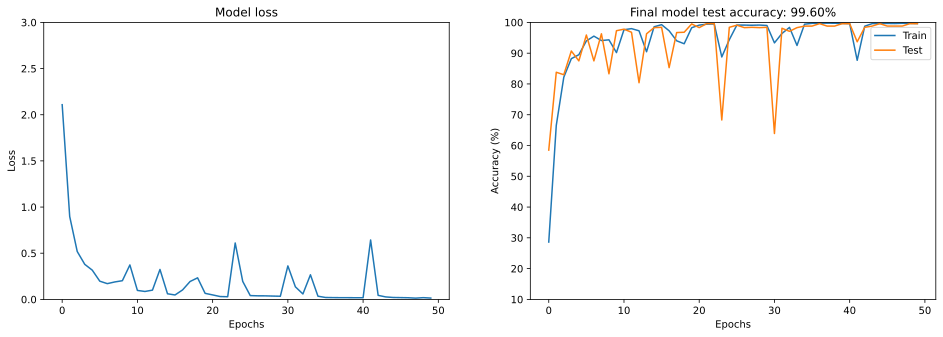

In [176]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(devAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {devAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [200]:
for i in range(10) :
  trainAcc,devAcc,losses,net = function2trainTheModel()
  X,y = test_dataset.tensors # extract X,y from devset dataloader
  bestnet = createAddingMachineNet()[0]
  bestnet.load_state_dict(net['net'])
  yHat = bestnet(X)
  testAcc = 100*torch.mean((torch.argmax(yHat,axis=1)==y).float())
  print(f"model instance {i}, train accuracy : {max(trainAcc)}, dev accuracy : {net['Accuracy']}, test Accuracy : {testAcc}")

  # compare the following really long line of code to the training accuracy lines


model instance 0, train accuracy : 99.01249694824219, dev accuracy : 96.9000015258789, test Accuracy : 97.5
model instance 1, train accuracy : 97.8375015258789, dev accuracy : 96.30000305175781, test Accuracy : 97.29999542236328
model instance 2, train accuracy : 99.6875, dev accuracy : 97.5999984741211, test Accuracy : 99.4000015258789
model instance 3, train accuracy : 99.73750305175781, dev accuracy : 99.5999984741211, test Accuracy : 99.69999694824219
model instance 4, train accuracy : 99.7125015258789, dev accuracy : 93.5999984741211, test Accuracy : 98.4000015258789
model instance 5, train accuracy : 99.67500305175781, dev accuracy : 98.9000015258789, test Accuracy : 99.29999542236328
model instance 6, train accuracy : 96.19999694824219, dev accuracy : 99.29999542236328, test Accuracy : 47.20000076293945
model instance 7, train accuracy : 99.07499694824219, dev accuracy : 95.0, test Accuracy : 97.5
model instance 8, train accuracy : 99.38749694824219, dev accuracy : 97.8999938964

In [202]:
X,y = test_dataset.tensors
testpredict = bestnet(X)

In [217]:
testpredict = torch.argmax(testpredict,axis=1)

In [214]:
testpredict

tensor([[-687.1508, -506.7462, -447.8096,  ..., -579.7623, -111.7627,
          -91.1871],
        [-906.0601, -685.0225, -564.0087,  ..., -766.5323, -152.7004,
         -151.1824],
        [-545.3093, -360.0088, -289.8861,  ..., -360.8710,  -93.6566,
          -68.8501],
        ...,
        [-613.0167, -431.1315, -367.0470,  ..., -468.4851, -102.4401,
          -79.7653],
        [-622.6566, -437.8695, -372.4497,  ..., -473.9797, -103.2487,
          -80.5253],
        [-237.3625, -111.9602,  -60.5846,  ..., -158.8454,  -84.1304,
          -51.1338]], grad_fn=<AddmmBackward0>)

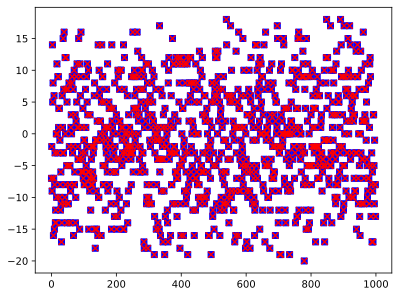

In [221]:
plt.scatter(np.arange(1000), y-20,  marker = 's', c = 'b')
plt.scatter(np.arange(1000), testpredict.detach()-20,  marker = 'x', c = 'r')